# Lung fibrosis v3 - ResNet34

This notebook uses the [dataset](https://osf.io/28qbc/) from the publication "[Deep neural network based histological scoring of lung fibrosis and inflammation in the mouse model system](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0202708)" to train an CNN based on a ResNet34 to characterize lung fibrosis from sections of lung tissue.<br><br>

**Publication benchmark:**<br>
Model: Inception V3, pretrained on ImageNet<br>
Accuracy: 0.795 (79.5%).<br><br>


<font color='blue'>**Notebook results:**<br>
Model: ResNet34, pretrained on ImageNet<br>
Data: training and validation data were used as in the provided dataset<br>
Training: image size of 224 for stage 1 and 2, image size of 512 for stage 3;<br>
stage 1: training of new network head;<br>
stage 2: training of the entire network with discriminative learning rates;<br>
stage 3: training of the entire network<br>
Accuracy: 0.810 (81,0%).<br><br>
    
**Summary:**<br>In this notebook it could be shown that state-of-the-art results published August 23 2018 could be  improved with a smaller model.

## Notebook setup

In [1]:
## notebook setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import fastai
from fastai import *
from fastai.vision import *

In [3]:
# set path
path = Path('/home/paperspace/fastai/data/lung'); path

PosixPath('/home/paperspace/fastai/data/lung')

## Setup data and model (stage 1 and 2)

### Data setup

In [4]:
# set batchsize and image size for network
bs = 32
size = 224

In [5]:
# different transformations (the increase of the max_rotate parameter is crucial to improve the performance)
#tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=10, max_zoom=1.1, max_lighting=0, max_warp=0.2) #1
#tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=45, max_zoom=1.1, max_lighting=0.1, max_warp=0.2) #2
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=90, max_zoom=1.1, max_lighting=0.1, max_warp=0.2) #3

In [6]:
# setup data with fastai data block API (https://docs.fast.ai/data_block.html)
data = (ImageFileList.from_folder(path/'lung_fibrosis', extensions='.png')\
        .label_from_folder() # get labels from folders\
        .split_by_folder() # split dataset by train/valid folders\
        .datasets(ImageClassificationDataset) # creat image classification dataset\
        .transform(tfms, size=size) # apply transformations and resize images\
        .databunch(bs=bs)) # creat databunch with bs

In [7]:
# normaliez data with ImagNet statistics
data.normalize(imagenet_stats);

In [8]:
# print class names, number of class, length of train dataset, and length of valid dataset
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['0', '3', 'ignore', '5', '7', '1'], 6, 12037, 2139)

### Model setup

A ResNet34 is setup with pretrained weights from Imagenet with a custom head, i.e. the final layers specific for ImageNet classification are removed and replaced by final layers suitable for our 5 classes.

In [9]:
!gpustat

psbtmxtmo  Fri Nov  2 11:04:41 2018
[0] Quadro P4000     | 60'C,  89 % |  1723 /  8119 MB | paperspace(1713M)


In [10]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

In [11]:
!gpustat

psbtmxtmo  Fri Nov  2 11:04:49 2018
[0] Quadro P4000     | 60'C,  76 % |  2312 /  8119 MB | paperspace(1713M) paperspace(589M)


## Training (stage 1 and 2)

### Stage 1 - Training of new head

In stage 1 only the new head of the network is trained and rest is frozen.

In [12]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


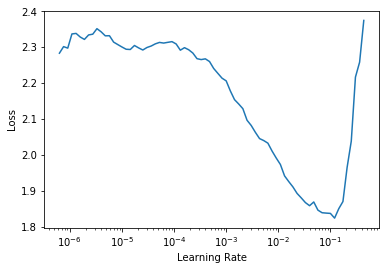

In [13]:
learn.recorder.plot()

In [14]:
lr = 1e-2

In [15]:
learn.fit_one_cycle(12, max_lr=lr)

Total time: 15:55
epoch  train_loss  valid_loss  accuracy
1      0.828589    0.780149    0.673212  (01:44)
2      0.741576    0.630900    0.733053  (01:42)
3      0.742223    0.796354    0.682562  (01:43)
4      0.720566    0.717227    0.714353  (01:43)
5      0.741380    0.679093    0.708742  (01:42)
6      0.698720    0.585635    0.740065  (01:40)
7      0.669014    0.927342    0.691445  (00:55)
8      0.645253    1.154109    0.640019  (01:01)
9      0.583231    0.531805    0.783076  (00:56)
10     0.579137    0.504265    0.796634  (00:55)
11     0.571375    0.481609    0.804114  (00:55)
12     0.569757    0.483858    0.805517  (00:54)



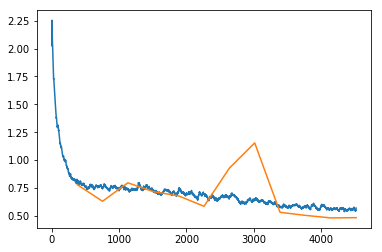

In [16]:
learn.recorder.plot_losses()

In [17]:
learn.save('lung_fib_v1-ResNet34_stage-1_20181102-1')

<font color=blue>**Conclusion stage 1 - Training of new head:**<br>
Training only the the new last layers from the new head (and keeping the rest of the network frozen) enabled the network to achieve a accuracy of approx. 0.80 (80%) after 12 epochs. This is already equal to the published accuracy benchmark!

### Stage 2 - Training of the entire network

In stage 2 the entire network is trained with discriminative learning rates, i.e. lower learning rates for the earyl layers and higher learning rates for the late layers.

In [19]:
learn.load('lung_fib_v1-ResNet34_stage-1_20181102-1')

In [20]:
learn.unfreeze()

In [21]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


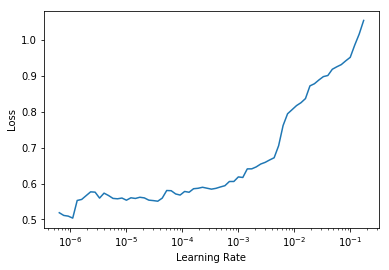

In [22]:
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(1, max_lr=slice(1e-6, 1e-4))

Total time: 01:13
epoch  train_loss  valid_loss  accuracy
1      0.582366    0.474463    0.809724  (01:13)



In [24]:
learn.fit_one_cycle(10, max_lr=slice(1e-6, 1e-4))

Total time: 12:27
epoch  train_loss  valid_loss  accuracy
1      0.527229    0.482763    0.810192  (01:13)
2      0.581523    0.474629    0.813932  (01:13)
3      0.583802    0.497284    0.802712  (01:14)
4      0.558672    0.488767    0.805049  (01:14)
5      0.517585    0.495058    0.795231  (01:14)
6      0.515425    0.490658    0.802244  (01:14)
7      0.550657    0.476721    0.805517  (01:16)
8      0.533346    0.489195    0.805984  (01:15)
9      0.559231    0.469281    0.808322  (01:15)
10     0.553029    0.485597    0.809724  (01:15)



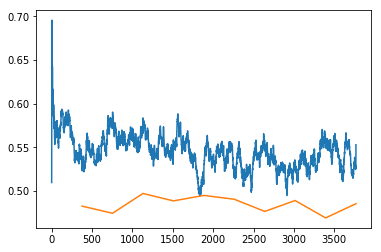

In [25]:
learn.recorder.plot_losses()

In [26]:
learn.save('lung_fib_v1-ResNet34_stage-2_20181102-2')

In [27]:
learn.load('lung_fib_v1-ResNet34_stage-2_20181102-2')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


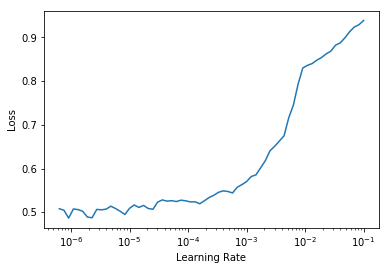

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(3, max_lr=slice(1e-6, 1e-5))

Total time: 03:45
epoch  train_loss  valid_loss  accuracy
1      0.553077    0.478608    0.807854  (01:14)
2      0.539804    0.486552    0.799906  (01:14)
3      0.537875    0.477289    0.810192  (01:15)



In [30]:
learn.save('lung_fib_v1-ResNet34_stage-2_20181102-2b')

In [31]:
learn.load('lung_fib_v1-ResNet34_stage-2_20181102-2b')

<font color=blue>**Conclusion stage 2 - Training of the entire network:**<br>
The training of the entire network with discriminative learning rates was able to reduce the training loss and increase the accuracy slightly.

## Setup data and model (stage 3)

### Data setup

In [32]:
!gpustat --no-header

[0] Quadro P4000     | 54'C,   0 % |  2367 /  8119 MB | paperspace(2357M)


In [33]:
# set batchsize and image size for network
bs = 32
size = 512

In [34]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=90, max_zoom=1.1, max_lighting=0.1, max_warp=0.2)

In [35]:
# setup data with fastai data block API (https://docs.fast.ai/data_block.html)
data = (ImageFileList.from_folder(path/'lung_fibrosis', extensions='.png')\
        .label_from_folder() # get labels from folders\
        .split_by_folder() # split dataset by train/valid folders\
        .datasets(ImageClassificationDataset) # creat image classification dataset\
        .transform(tfms, size=size) # apply transformations and resize images\
        .databunch(bs=bs)) # creat databunch with bs

In [36]:
# normaliez data with ImagNet statistics
data.normalize(imagenet_stats);

### Model setup

In [37]:
!gpustat --no-header

[0] Quadro P4000     | 52'C,   0 % |  2367 /  8119 MB | paperspace(2357M)


In [38]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

In [39]:
learn.load('lung_fib_v1-ResNet34_stage-2_20181102-2b')

In [40]:
learn.unfreeze()

In [41]:
!gpustat --no-header

[0] Quadro P4000     | 51'C,   0 % |  2367 /  8119 MB | paperspace(2357M)


## Training (stage 3)

### Stage 3 - Increased image size

In [42]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


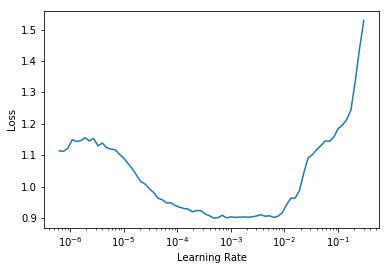

In [43]:
learn.recorder.plot()

In [44]:
lr = 1e-5

In [45]:
learn.fit_one_cycle(3, max_lr=lr)

Total time: 15:01
epoch  train_loss  valid_loss  accuracy
1      0.607295    0.491760    0.796634  (05:02)
2      0.551332    0.496411    0.798036  (04:59)
3      0.527806    0.484999    0.796634  (04:59)



In [46]:
learn.fit_one_cycle(10, max_lr=lr)

Total time: 50:46
epoch  train_loss  valid_loss  accuracy
1      0.556409    0.485439    0.800842  (05:01)
2      0.538068    0.586151    0.757363  (05:04)
3      0.536873    0.472031    0.801309  (05:04)
4      0.526030    0.453783    0.814867  (05:04)
5      0.535214    0.471624    0.798036  (05:04)
6      0.524156    0.460152    0.808789  (05:04)
7      0.502770    0.466428    0.800374  (05:05)
8      0.501919    0.453979    0.807387  (05:05)
9      0.498651    0.458332    0.803179  (05:05)
10     0.500597    0.450935    0.810659  (05:04)



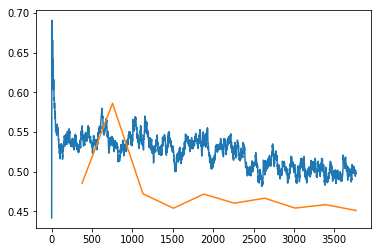

In [47]:
learn.recorder.plot_losses()

In [48]:
learn.save('lung_fib_v1-ResNet34_stage-3_20181102-3')

In [49]:
learn.load('lung_fib_v1-ResNet34_stage-3_20181102-3')

## Interpretation

In [50]:
interp = ClassificationInterpretation.from_learner(learn)

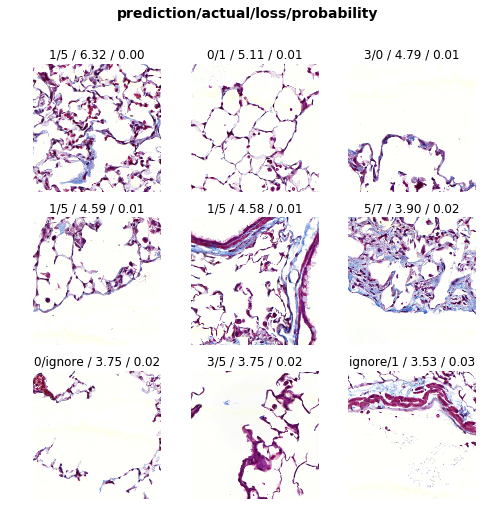

In [51]:
interp.plot_top_losses(9, figsize=(8,8))

In [52]:
interp.confusion_matrix()

array([[812,   1,   5,   0,   0,  69],
       [  2, 204,  12,  14,   0,  60],
       [ 15,   6, 233,   4,   0,   9],
       [  0,  37,   6, 119,   4,   4],
       [  0,   0,   1,  33,  31,   0],
       [ 55,  65,   3,   0,   0, 335]])

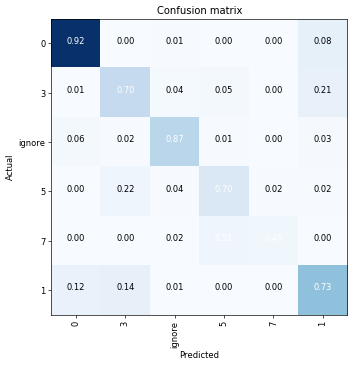

In [53]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60, normalize=True)